In [536]:
import numpy as np
import pandas as pd
import random
import time

df = pd.read_table("./eil101.tsp.txt", sep=' ', header=None)
tour = pd.read_table("./eil101.tour.txt", header=None)
tour -= 1
tsp = df.copy()
tsp = tsp.reindex(tour.iloc[:, 0])
np.sum(np.linalg.norm(tsp.iloc[:, 1:3] - np.roll(tsp.iloc[:, 1:3], 1, axis=0)))

69.46941773183363

In [538]:
class SOM:
    def __init__(self, cities, lr, it, k):       
        self.lr = lr
        self.it = it
        self.num = cities.shape[0]*8
        ratio = np.minimum(np.array((cities.iloc[:, 0].max() - cities.iloc[:, 0].min()) / (cities.iloc[:, 1].max() - cities.iloc[:, 1].min())), 1)
        norm = cities.apply(lambda c: (c - c.min()) / (c.max() - c.min()))
        self.cities = norm.apply(lambda p: (ratio * p), axis=1)
        self.min_dist = get_cities_min_dist(self.cities)
        self.neuron = np.random.rand(self.num, 2)
        self.k = k
        self.interval = [0,]
        self.neuron_list = np.arange(self.num - 1)
        if k > 1:
            for i in range(k - 1):
                self.interval.append(random.choice(self.neuron_list))
            self.interval.append(self.num - 1)
            self.interval.sort()

            
    def iterate(self):
        for i in range(self.it):
            if i % 1000 == 0:
                print('Iteration %d / %d' % (i, self.it))
            city = self.cities.sample(1).values
            winner_idx = get_closest_idx(self.neuron, city)
            if(np.linalg.norm(self.neuron[winner_idx] - city) <= 0.3*self.min_dist):
                self.neuron[winner_idx] = city
            neig_scope = get_neig_scope(winner_idx, self.num // 10, self.neuron.shape[0])           
            self.neuron += neig_scope[:, np.newaxis] * self.lr * (city - self.neuron)
            self.num *= 0.9997
            self.lr *= 0.99997
            if self.num < 1:
                print('Radius has completely decayed, finishing execution','at {} iterations'.format(i))
                break
            if self.lr < 0.001:
                print('Learning rate has completely decayed, finishing execution','at {} iterations'.format(i))
                break
            
        print('Done!')
        
    def iterate_mul(self): 
        for i in range(self.it):
            if i % 1000 == 0:
                print('Iteration %d / %d' % (i, self.it))
            city = self.cities.sample(1).values
            winner_idx = get_closest_idx(self.neuron, city)
            if(np.linalg.norm(self.neuron[winner_idx] - city) <= 0.3*self.min_dist):
                self.neuron[winner_idx] = city
            idx = self.get_salesman(winner_idx)
            if idx == 1:
                neig_scope = get_neig_scope_mul(winner_idx, self.num // 10, 0,
                                                self.interval[idx] + 1)
                self.neuron[0:self.interval[idx] + 1, :] += neig_scope[:, np.newaxis] * self.lr * (city - self.neuron[0:self.interval[idx] + 1, :])
                
            else:
                neig_scope = get_neig_scope_mul(winner_idx, self.num // 10,
                                                self.interval[idx - 1] + 1, self.interval[idx] + 1)
                self.neuron[(self.interval[idx - 1] + 1):(self.interval[idx] + 1), :] += neig_scope[:, np.newaxis] * self.lr * (city - self.neuron[(self.interval[idx - 1] + 1):(self.interval[idx] + 1), :])
            self.num *= 0.9997
            self.lr *= 0.99997
            if self.num < 1:
                print('Radius has completely decayed, finishing execution','at {} iterations'.format(i))
                break
            if self.lr < 0.001:
                print('Learning rate has completely decayed, finishing execution','at {} iterations'.format(i))
                break
            
    def get_salesman(self, winner_idx):
        for i, itv in enumerate(self.interval):
            if i == 0:
                continue
            if winner_idx <= itv:
                return i
            
    def get_route(self):
        self.cities['winner'] = self.cities.apply(lambda c: 
                                                  get_closest_idx
                                                  (self.neuron, c),
                                                  axis=1,
                                                  raw=True)
        return self.cities.sort_values('winner').index
        
def get_closest_idx(candi, ori):
    return np.linalg.norm(candi - ori, axis=1).argmin()


def get_neig_scope(winner, variance, num):
    diff = np.absolute(winner - np.arange(num))
    dist = np.minimum(diff, num - diff)
    return np.exp(-(dist*dist) / (2*variance*variance + 0.000001))

def get_neig_scope_mul(winner, variance, offset, end):
    diff = np.absolute(winner - np.arange(offset, end))
    dist = np.minimum(diff, end - offset - diff)
    return np.exp(-(dist*dist) / (2*variance*variance + 0.000001))

def get_cities_min_dist(cities):
    dist = []
    for i in range(cities.shape[0]):
        for j in range(i+1, cities.shape[0]):
            dist.append(np.linalg.norm(cities.iloc[i] - cities.iloc[j]))
    return np.min(dist)



In [549]:
start = time.perf_counter()
SOM_instance = SOM(df.iloc[:, 1:3], 0.8, 50000, 1)
if(SOM_instance.k > 1):
    SOM_instance.iterate_mul()
else:
    SOM_instance.iterate()
print('%s' % (time.perf_counter() - start))

Iteration 0 / 50000
Iteration 1000 / 50000
Iteration 2000 / 50000
Iteration 3000 / 50000
Iteration 4000 / 50000
Iteration 5000 / 50000
Iteration 6000 / 50000
Iteration 7000 / 50000
Iteration 8000 / 50000
Iteration 9000 / 50000
Iteration 10000 / 50000
Iteration 11000 / 50000
Iteration 12000 / 50000
Iteration 13000 / 50000
Iteration 14000 / 50000
Iteration 15000 / 50000
Iteration 16000 / 50000
Iteration 17000 / 50000
Iteration 18000 / 50000
Iteration 19000 / 50000
Iteration 20000 / 50000
Iteration 21000 / 50000
Iteration 22000 / 50000
Radius has completely decayed, finishing execution at 22311 iterations
Done!
7.983021199994255


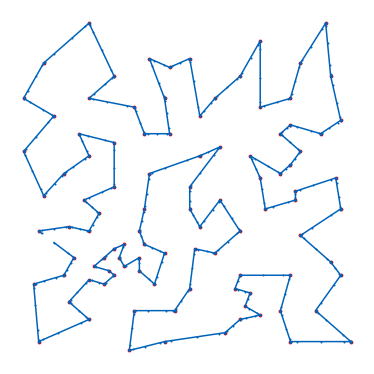

In [550]:
import matplotlib.pyplot as plt
import matplotlib as mpl

colors = ['gold','darkgreen', '#0063ba', 'brown', 'olive', 'orange', 'violet', 'dimgray']
fig = plt.figure(figsize=(5, 5), frameon = False)
axis = fig.add_axes([0,0,1,1])

axis.set_aspect('equal', adjustable='datalim')
plt.axis('off')

axis.scatter(SOM_instance.cities.iloc[:, 0], SOM_instance.cities.iloc[:, 1], color='red', s=8)
if SOM_instance.k > 1:
    for i in range(1, SOM_instance.k + 1):
        if i == 1:
            axis.plot(SOM_instance.neuron[0:SOM_instance.interval[i] + 1, 0], SOM_instance.neuron[0:SOM_instance.interval[i] + 1, 1], 'r.', ls='-', color=colors[i - 1], markersize=2)
        else:
            axis.plot(SOM_instance.neuron[(SOM_instance.interval[i - 1] + 1):(SOM_instance.interval[i] + 1), 0], SOM_instance.neuron[(SOM_instance.interval[i - 1] + 1):(SOM_instance.interval[i] + 1), 1], 'r.', ls='-', color=colors[i - 1], markersize=2)
else:
    axis.plot(SOM_instance.neuron[:, 0], SOM_instance.neuron[:, 1], 'r.', ls='-', color='#0063ba', markersize=2)



In [541]:
# 以下是计算实际的最短路径
cities = df.copy()
cities = cities.reindex(SOM_instance.get_route())
# np.sum(np.linalg.norm(df.iloc[:, 1:3] - np.roll(df.iloc[:, 1:3], 1, axis=0)))

In [530]:
shortest_route = 0
if SOM_instance.k == 1:   
    shortest_route = np.sum(np.linalg.norm(cities.iloc[:, 1:3] - np.roll(cities.iloc[:, 1:3], 1, axis=0)))
else:    
    for i in range(1, SOM_instance.k + 1):
        shortest_route += np.sum(np.linalg.norm
                                 (cities.iloc[SOM_instance.interval[i-1]:SOM_instance.interval[i], 1:3]
                                  - np.roll(cities.iloc[SOM_instance.interval[i-1]:SOM_instance.interval[i], 1:3], 1, axis=0)))

In [531]:
shortest_route

738.7083321582342